In [6]:
import geopandas as geopd
import pandas as pd
from shapely.geometry import box

import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds

import numpy as np

try:# yoga
    from whitebox.WBT.whitebox_tools import WhiteboxTools
except:# fossa
    from whitebox.whitebox_tools import WhiteboxTools

import os

from time import sleep

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [7]:
gauge_path = "/home/iiro/Documents/DIWA/data/SYKE/flow/measurement_locations.gpkg"
catchments_path = "/home/iiro/Documents/DIWA/data/omat digitoinnit/suitable_watersheds.gpkg"
gauges = geopd.read_file(gauge_path, layer="suitable_from_1995")
catchments = geopd.read_file(catchments_path, layer='all')

catchments = catchments.reset_index(names=['catch_id'])

gauges = geopd.sjoin(gauges[['Paikka_Id', 'geometry']], catchments[['catch_id', 'geometry']], how='left')
gauges = gauges.drop('index_right', axis=1)

In [8]:
assert gauges['catch_id'].isna().sum() == 0, "Some points fall outside the catchments"

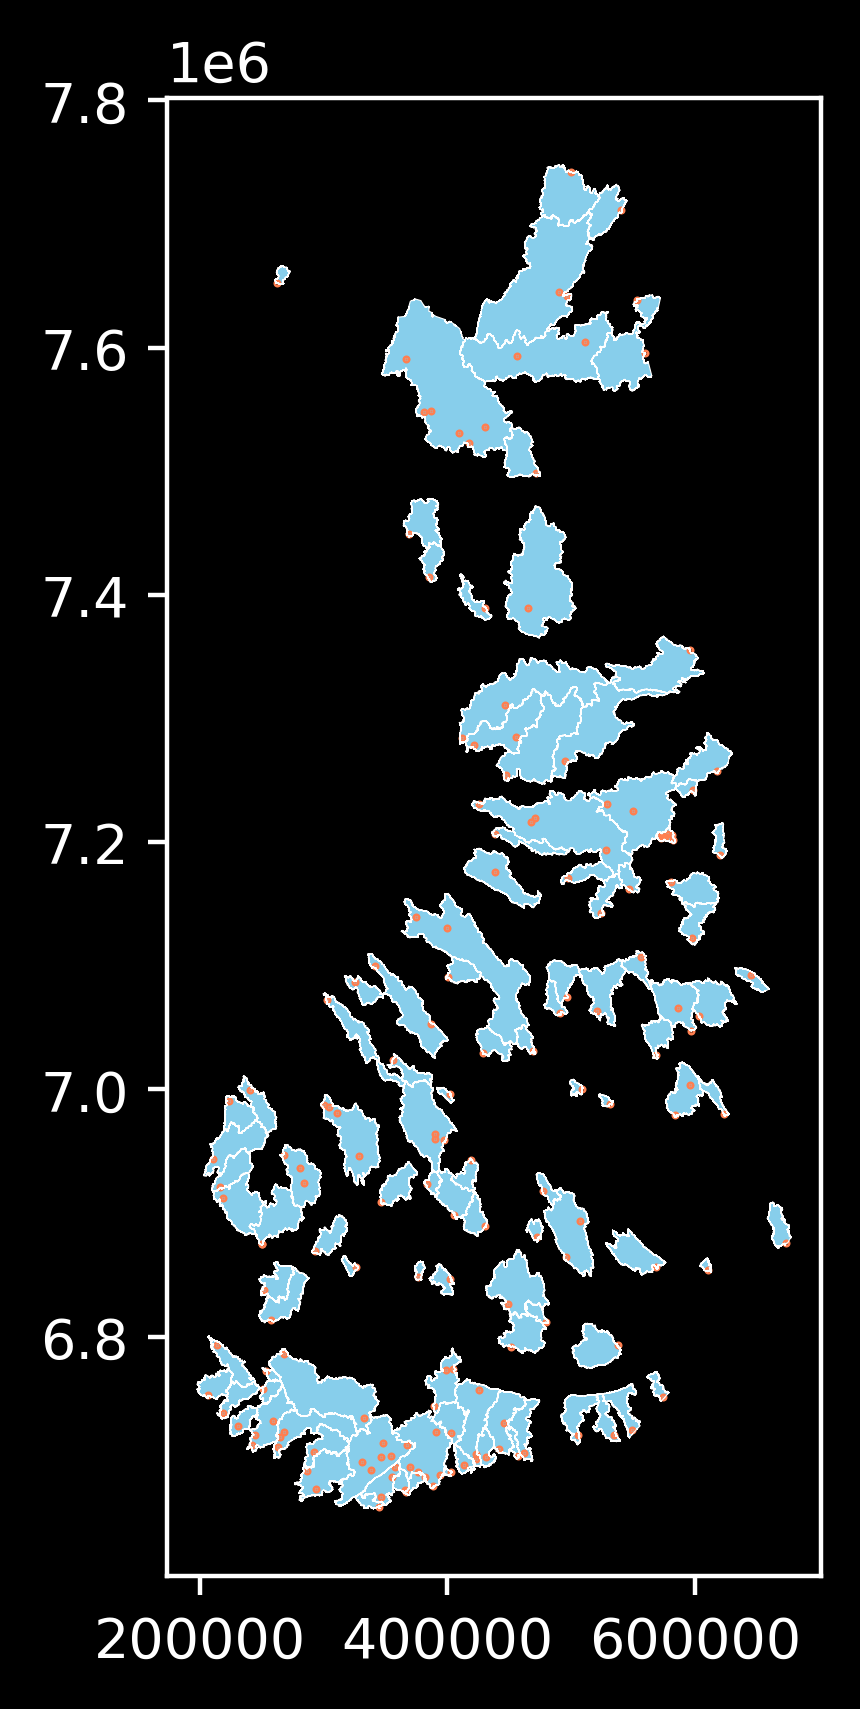

In [9]:

ax = catchments.boundary.plot(linewidth=0.2)
ax = catchments.plot(ax=ax, color='skyblue')
ax = gauges.plot(ax=ax, markersize=0.2, color='coral')

In [10]:
wbt = WhiteboxTools()
wbt.set_verbose_mode(False)

root = "/media/iiro/T9/gisT7/korkeusmalli_10_m"

stream_dir = os.path.join(root, "stream_thresholding")
d8_dir = os.path.join(root, "d8_pointer")

tmp_dir = "/tmp/stream_processing"
if not os.path.isdir(tmp_dir):
        os.mkdir(tmp_dir)
    
point_tmp_path = os.path.join(tmp_dir, "pour_points.shp")
snapped_tmp_path = os.path.join(tmp_dir, "snapped_points.shp")

with tqdm(catchments.iterrows(), total=len(catchments)) as pbar:
    for i, catchment in pbar:
        locations = gauges.loc[gauges['catch_id'] == i]
        counter = 0

        stream_path = os.path.join(stream_dir, f"stream_thresholding_{i}.tif")
        d8_path = os.path.join(d8_dir, f"d8_pointer_{i}.tif")

        
        """
        Every pour point needs to be processed separately so that whiteboxtools will handle it correctly
        and generate the entire watershed for the pour point.
        """
        for j, location in locations.iterrows():
            counter += 1
            pbar.set_description(f"processing pour point {counter}/{len(locations)} of catchment {i}")

             # Converting from series to GeoDataFrame
            location = geopd.GeoDataFrame(
                    dict(zip(list(location.index), list(location.values))),
                    crs=locations.crs, geometry='geometry', index=[0])

            # Each watershed is put to directory watershed/pour_point_id/full
            # The watershed will later be subdivided  and that will be put to watershed/pour_point_id/subshed
            dst_dir = os.path.join(root, "watershed", location.at[0, 'Paikka_Id'], "full")
            
            if not os.path.isdir(dst_dir):
                os.makedirs(dst_dir)
            
            watershed_path = os.path.join(dst_dir, f"watershed_{location.at[0, 'Paikka_Id']}.tif")
            
            location.to_file(point_tmp_path)
            # snapping to flow path
            wbt.jenson_snap_pour_points(point_tmp_path, stream_path, snapped_tmp_path, 500)

            # Watershed calculation
            wbt.watershed(d8_path, snapped_tmp_path, watershed_path)
            

  0%|          | 0/111 [00:00<?, ?it/s]

In [11]:
location.

,Paikka_Id,geometry,catch_id
0,3682,POINT (570738 6753256),0


In [29]:
geopd.sjoin(gauges[['Paikka_Id', 'geometry']], catchments[['catchment_id', 'geometry']], how='left')

,Paikka_Id,geometry,index_right,catchment_id
0,896,POINT (673968 6876149),80,80
1,900,POINT (649728 7051867),56,56
2,905,POINT (603681 7059048),55,55
3,907,POINT (586853 7065717),54,54
4,930,POINT (490849 7061606),69,69
...,...,...,...,...
144,1272,POINT (582637 7202052),77,77
145,1272,POINT (582637 7202052),77,77
146,938,POINT (508825 6999985),78,78
147,6471,POINT (355962.002 7023444.435),28,28


In [28]:
catchments

,catchment_id,taso2_osai,taso2_osat,taso2_id,paavesisto,nimi,osavalu_pa,ylavalu_pa,taso1_osat,valtio,muutospvm,Shape_STAr,Shape_STLe,geometry
0,0,1106.0,FI1-06,106.0,6.0,Hounijoen vesistöalue,367.23,595.83,FI1,FIRU1,2023-05-09,3.672258e+08,168402.890561,"MULTIPOLYGON (((560930 6751100, 560920 6751100..."
1,1,1109.0,FI1-09,109.0,9.0,Urpalanjoen vesistöalue,462.89,562.66,FI1,FIRU1,2023-05-09,4.628933e+08,277174.432081,"MULTIPOLYGON (((540560 6735460, 540570 6735460..."
2,2,1111.0,FI1-11,111.0,11.0,Vironjoen vesistöalue,359.33,359.33,FI1,FI,2023-05-09,3.593266e+08,246320.000000,"MULTIPOLYGON (((536420 6720490, 536420 6720480..."
3,3,1113.0,FI1-13,113.0,13.0,Summajoen vesistöalue,563.68,563.68,FI1,FI,2023-05-09,5.636818e+08,278300.000000,"MULTIPOLYGON (((493410 6729850, 493400 6729850..."
4,4,1115.0,FI1-15,115.0,15.0,Taasianjoen vesistöalue,527.46,527.46,FI1,FI,2023-05-09,5.274585e+08,326980.000000,"MULTIPOLYGON (((461680 6700750, 461670 6700750..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,NaN,FI1-61,NaN,NaN,None,1237.47,2394.62,FI1,FI,2023-05-09,1.237470e+07,29520.000000,"MULTIPOLYGON (((478880 7249390, 478880 7249380..."
77,77,NaN,FI1-59,NaN,NaN,None,69.89,14.38,FI1,FI,2023-05-09,6.989000e+05,4980.000000,"MULTIPOLYGON (((582590 7203620, 582590 7203610..."
78,78,NaN,FI2-04,NaN,NaN,None,762.08,21.65,FI2,FI,2023-05-09,7.620800e+06,25800.000000,"MULTIPOLYGON (((504220 6997730, 504230 6997730..."
79,79,NaN,FI1-47,NaN,NaN,None,775.43,775.43,FI1,FI,2023-05-09,7.754251e+08,516540.000000,"MULTIPOLYGON (((308350 7063930, 308350 7063940..."
